In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super(ConvBlock, self).__init__()
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ELU())
            in_channels = out_channels
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class RBFNet(nn.Module):
    def __init__(self, in_features, out_features, num_centers):
        super(RBFNet, self).__init__()
        self.num_centers = num_centers
        
        # Define the weights, centers, and bandwidths as trainable parameters
        self.centers = nn.Parameter(torch.randn(num_centers, in_features))
        self.bandwidths = nn.Parameter(torch.ones(num_centers))
        self.weights = nn.Linear(num_centers, out_features, bias=False)

    def forward(self, x):
        # Calculate the squared Euclidean distance between input and centers
        expanded_x = x.unsqueeze(1).expand(-1, self.num_centers, -1)  # Shape: (batch_size, num_centers, in_features)
        expanded_centers = self.centers.unsqueeze(0).expand(x.size(0), -1, -1)  # Shape: (batch_size, num_centers, in_features)
        distances = torch.norm(expanded_x - expanded_centers, dim=2) ** 2  # Shape: (batch_size, num_centers)
        
        # Calculate the RBF activation
        rbf_activations = torch.exp(-distances / (2 * self.bandwidths ** 2))  # Shape: (batch_size, num_centers)
        
        # Pass through the weights to get the output
        output = self.weights(rbf_activations)
        return output


class ConvNet2D(nn.Module):
    def __init__(self):
        super(ConvNet2D, self).__init__()
        self.encoder1 = ConvBlock(1, 64, num_convs=2)
        self.encoder2 = ConvBlock(64, 128, num_convs=2)
        self.encoder3 = ConvBlock(128, 256, num_convs=4)
        self.encoder4 = ConvBlock(256, 512, num_convs=4)
        
        self.pool = nn.MaxPool2d(2)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.rbf_net = RBFNet(512, 3242, num_centers=512)

    def forward(self, x):
        # Encoder path
        x1 = self.encoder1(x)
        x2 = self.pool(x1)
        
        x3 = self.encoder2(x2)
        x4 = self.pool(x3)
        
        x5 = self.encoder3(x4)
        x6 = self.pool(x5)
        
        x7 = self.encoder4(x6)

        # Global Average Pooling
        x8 = self.global_avg_pool(x7)
        
        # Flatten before feeding to RBF network
        x8 = x8.view(x8.size(0), -1)
        output = self.rbf_net(x8)

        return output


# Example usage
model = ConvNet2D()
input_tensor = torch.randn(1, 1, 16, 13)  # Batch size 1, 1 input channel, 256x256 image
output = model(input_tensor)
print(output.shape)  # Should print torch.Size([1, 3242])


torch.Size([1, 3242])


Total number of pixels equal to 1: 3242


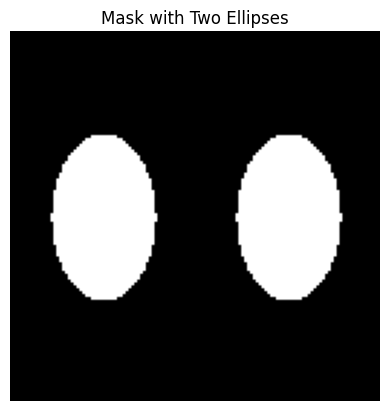

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import ellipse

def create_ellipse_mask(center, axes, height, width):
    """
    Create a binary mask with a single ellipse.
    
    Parameters:
    - center: Tuple (y_center, x_center) - Center of the ellipse
    - axes: Tuple (a, b) - Axes lengths of the ellipse
    - height: Height of the mask
    - width: Width of the mask
    
    Returns:
    - Binary mask with the ellipse
    """
    mask = np.zeros((height, width), dtype=np.uint8)
    rr, cc = ellipse(center[0], center[1], axes[0], axes[1], shape=mask.shape)
    mask[rr, cc] = 1
    return mask

# Define the size of the mask
height, width = 128, 128

# Ellipse parameters
ellipse1_center = (height // 2, width // 4)
ellipse1_axes = (height * 0.225, width * 0.1408)

ellipse2_center = (height // 2, width * 3 // 4)
ellipse2_axes = (height * 0.225, width * 0.1408)

# Create masks for each ellipse
mask1 = create_ellipse_mask(ellipse1_center, ellipse1_axes, height, width)
mask2 = create_ellipse_mask(ellipse2_center, ellipse2_axes, height, width)

# Combine masks
combined_mask = np.maximum(mask1, mask2)

# Count the number of pixels set to 1
num_ones = np.sum(combined_mask)

# Print the number of pixels with value 1
print(f"Total number of pixels equal to 1: {num_ones}")

# Plot the combined mask
plt.imshow(combined_mask, cmap='gray')
plt.title("Mask with Two Ellipses")
plt.axis('off')
plt.show()


In [76]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import binary_erosion
import fnmatch
import torch
from train.testing import testing
from data_processing.dataset_3d import load_dataset_3d
from data_processing.obj2py import read_get, read_mat, read_egt
from data_processing.helper import sort_filenames, erode_lung_masks, combine_electrode_positions
import copy
from plotting_helper import *

In [82]:
eit_path = 'outputs/2024-08-21/16-15-17'
model, cfg = load_model(eit_path)#, device='cuda:1')
cases = get_all_cases(cfg, base_dir='')    
train_dataset, val_dataset, test_dataset = load_dataset_3d(cases,
            resolution=cfg.data.resolution, 
            base_dir = '',
            raw_data_folder=cfg.data.raw_data_folder, 
            processed_data_folder='data/processed/3d_15',
            dataset_data_folder=cfg.data.dataset_data_folder,
            name_prefix=cfg.data.name_prefix,
            write_dataset=True, write_npz=True, 
            overwrite_npz=False, n_sample_points=cfg.learning.training.sample_points,
            apply_rotation=False,
            apply_subsampling=False,
            apply_translation = False,
            translation_x=cfg.data.translation_x, translation_y=cfg.data.translation_y, translation_z=cfg.data.translation_z,
            point_levels_3d=4,
            multi_process=cfg.data.multi_process, num_workers=cfg.data.num_workers,
            signal_norm='all',
            normalize_space='xy',
            include_resistivities=[5, 15, 10, 20]
            )
test_dataset.case_files = sort_filenames(test_dataset.case_files)

Using 128 workers.


237it [00:37,  6.37it/s]


Training set: 639, validation set: 96, test set: 120


In [83]:
for points, signals, electrodes, mask, targets, tissue in train_dataset:
    print(targets.reshape())
    break

torch.Size([3932160, 1])


In [87]:
targets[mask.reshape(-1)].mean()

/scratch/tmp/nibdombe/ipykernel_1110/3738553765.py:1: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847130/work/aten/src/ATen/native/IndexingUtils.h:27.)
  targets[mask.reshape(-1)].mean()


tensor(0.2000)

In [131]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import wandb
import sys

sys.path.append("../")
from utils.helper import log_heatmaps, make_cmap

def training(
    model,
    train_dataset,
    val_dataset,
    epochs,
    batch_size_train,
    lr,
    device,
    loss_lung_multiplier=1,
    batch_size_val=2,
    point_levels_3d=9,
    output_dir=None,
):
    print("Initializing Dataloader...", end=" ")
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size_train, shuffle=True
    )
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)
    print("Done.")
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=100, gamma=0.5)

    loss = nn.MSELoss(reduction="none")
    pbar = tqdm(range(epochs))
    best_val_loss = 100
    cmap = make_cmap()
    for epoch in pbar:
        epoch_loss_train, epoch_lung_loss_train, model, optimizer = training_step(
            model,
            train_dataloader,
            optimizer,
            lr,
            loss,
            device,
            epoch,
            loss_lung_multiplier,
        )
        scheduler.step()
        torch.cuda.empty_cache()
        if epoch % 1 == 0:  # and epoch!=0:
            epoch_loss_val = (
                validation_step(
                    model,
                    val_dataloader,
                    loss,
                    device,
                    cmap,
                    point_levels_3d=point_levels_3d,
                    loss_lung_multiplier=loss_lung_multiplier,
                )
            )
        pbar.set_description(
            f"Epoch: {epoch+1}, Train Loss: {epoch_loss_train:.5f}, Val Loss: {epoch_loss_val:.5f}"
        )
        if epoch_loss_val < best_val_loss:
            best_val_loss = epoch_loss_val
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": loss,
            }
            # torch.save(checkpoint, os.path.join(output_dir, "model.pt"))
        # wandb.log(
        #     {
        #         "train_loss": epoch_loss_train,
        #         "val_loss": epoch_loss_val,
        #         "best_val_loss": best_val_loss,
        #     }
        # )
    return model


def training_step(
    model, dataloader, optimizer, lr, loss, device, epoch, loss_lung_multiplier
):
    model.train()
    model.to(device)
    epoch_loss = 0
    lung_loss = 0
    for i, (points, signals, electrodes, mask, targets, tissue) in enumerate(
        dataloader
    ):
        optimizer.zero_grad()
        
        signals = signals.reshape(-1, 1, 16, 13)
        
        pred = model(
            signals.to(device)
        )
        mask = mask.reshape(targets.shape[0], -1)
        targets = targets.reshape(targets.shape[0], -1)
        cond =[]
        for i in range(targets.shape[0]):
            cond.append(targets[i][mask[i]==1].mean())
        cond = torch.tensor(cond)
        cond = torch.tile(cond, (4,1)).to(device).reshape(-1,1)
        targets = torch.ones_like(pred).to(device) * cond
        l = loss(pred, targets)
        l = l.mean()
        l.backward()
        optimizer.step()
        epoch_loss += l.detach().cpu()
    epoch_loss /= i + 1
    lung_loss /= i + 1
    return epoch_loss, lung_loss, model, optimizer


def validation_step(
    model,
    dataloader,
    loss,
    device,
    cmap,
    point_levels_3d=6,
    n_examples=4,
    loss_lung_multiplier=1,
):
    model.eval()
    model.to(device)
    epoch_loss = 0
    for i, (points, signals, electrodes, mask, targets, tissue) in enumerate(
        dataloader
    ):
        
        signals = signals.reshape(-1, 1, 16, 13)
        
        pred = model(
            signals.to(device)
        )
        mask = mask.reshape(targets.shape[0], -1)
        targets = targets.reshape(targets.shape[0], -1)
        cond =[]
        for i in range(targets.shape[0]):
            cond.append(targets[i][mask[i]==1].mean())
        cond = torch.tensor(cond)
        cond = torch.tile(cond, (4,1)).to(device).reshape(-1,1)
        targets = torch.ones_like(pred).to(device) * cond
        l = loss(pred, targets)
        l = l.mean()
        epoch_loss += l.detach().cpu()
    epoch_loss /= i + 1
    return epoch_loss

In [133]:
model = ConvNet2D()
training(model,
    train_dataset,
    val_dataset,
    epochs=10,
    batch_size_train=12,
    lr=0.001,
    device='cuda')

Initializing Dataloader... Done.


Epoch: 10, Train Loss: 0.31813, Val Loss: 0.34167: 100%|██████████| 10/10 [46:03<00:00, 276.34s/it]


ConvNet2D(
  (encoder1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (encoder2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (encoder3): ConvBlock(
    (block): Sequential(
      (0): Conv2d(128, 256, kernel_size

In [118]:
targets[mask.reshape(-1)].mean()

/scratch/tmp/nibdombe/ipykernel_1110/713906156.py:1: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847130/work/aten/src/ATen/native/IndexingUtils.h:27.)
  targets[mask.reshape(-1)].mean(


tensor(0.2000)